# USAD

## Environment

In [1]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [2]:
!git clone https://github.com/manigalati/usad

In [3]:
%cd usad

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [5]:
!nvidia-smi -L

device = get_default_device()

GPU 0: Quadro P6000 (UUID: GPU-e16b9553-c966-4659-d528-7376969c0e91)
GPU 1: Quadro P6000 (UUID: GPU-def1ffb6-415d-a3f6-288b-94256f1ba88f)
GPU 2: GeForce GTX 1080 Ti (UUID: GPU-075162a2-c2cc-7757-e07d-e1260458102e)
GPU 3: GeForce GTX 1080 Ti (UUID: GPU-078c9ebd-10e3-2644-2267-bfcf3135c6a1)
GPU 4: GeForce GTX 1080 Ti (UUID: GPU-db4d0970-82a3-4f24-d69f-423377f7d3c0)
GPU 5: GeForce GTX 1080 Ti (UUID: GPU-945cc499-5f5f-ee9f-5b21-69a0e2e06535)
GPU 6: GeForce GTX 1080 Ti (UUID: GPU-07966339-f324-1615-decf-f4825e865008)
GPU 7: GeForce GTX 1080 Ti (UUID: GPU-dfa6e9f2-3de4-2115-3363-4329ff29ba3f)


## EDA - Data Pre-Processing

### Download dataset

In [6]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

mkdir: cannot create directory 'input': File exists
input/SWaT_Dataset_Normal_v1.csv [Exists]
input/SWaT_Dataset_Attack_v0.csv [Exists]


### Normal period

In [2]:
#Read data
normal = pd.read_csv("../datasets/SWaT/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

C:\Users\alexr\AppData\Local\Temp\ipykernel_35524\572630714.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv("../datasets/SWaT/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)


(495000, 51)

In [3]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [4]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [5]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [6]:
#Read data
attack = pd.read_csv("../datasets/SWaT/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

C:\Users\alexr\AppData\Local\Temp\ipykernel_35524\3987130262.py:2: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("../datasets/SWaT/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)


(449919, 51)

In [7]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [8]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [9]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [10]:
window_size=12

In [11]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [12]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [13]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [14]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0259, val_loss2: 0.0256
Epoch [1], val_loss1: 0.0251, val_loss2: -0.0060
Epoch [2], val_loss1: 0.0192, val_loss2: -0.0065
Epoch [3], val_loss1: 0.0165, val_loss2: -0.0087
Epoch [4], val_loss1: 0.0159, val_loss2: -0.0098
Epoch [5], val_loss1: 0.0157, val_loss2: -0.0109
Epoch [6], val_loss1: 0.0164, val_loss2: -0.0123
Epoch [7], val_loss1: 0.0165, val_loss2: -0.0129
Epoch [8], val_loss1: 0.0155, val_loss2: -0.0125
Epoch [9], val_loss1: 0.0148, val_loss2: -0.0119
Epoch [10], val_loss1: 0.0142, val_loss2: -0.0119
Epoch [11], val_loss1: 0.0165, val_loss2: -0.0140
Epoch [12], val_loss1: 0.0156, val_loss2: -0.0135
Epoch [13], val_loss1: 0.0145, val_loss2: -0.0126
Epoch [14], val_loss1: 0.0146, val_loss2: -0.0129
Epoch [15], val_loss1: 0.0144, val_loss2: -0.0129
Epoch [16], val_loss1: 0.0150, val_loss2: -0.0135
Epoch [17], val_loss1: 0.0144, val_loss2: -0.0131
Epoch [18], val_loss1: 0.0133, val_loss2: -0.0121
Epoch [19], val_loss1: 0.0151, val_loss2: -0.0139
Epoch [20],

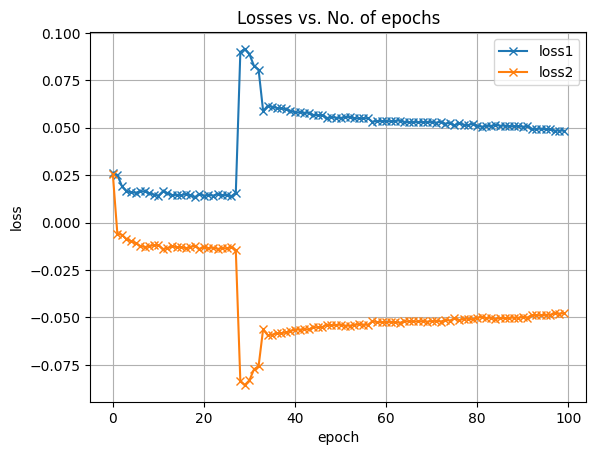

In [15]:
plot_history(history)

In [21]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [22]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [16]:
results=testing(model,test_loader)

In [41]:
len(results)

57

In [17]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [18]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [19]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

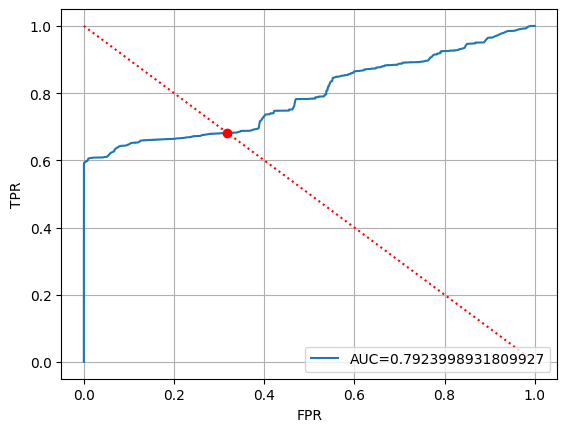

In [20]:
threshold=ROC(y_test,y_pred)

In [23]:
print(len(results))

57


In [25]:
print(results)

[tensor([0.0127, 0.0127, 0.0128,  ..., 0.0548, 0.0548, 0.0548], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([0.0548, 0.0548, 0.0548,  ..., 0.1716, 0.1718, 0.1721], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([0.1723, 0.1726, 0.1728,  ..., 0.0128, 0.0128, 0.0128], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([0.0128, 0.0128, 0.0129,  ..., 0.0274, 0.0274, 0.0274], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([0.0274, 0.0274, 0.0274,  ..., 0.0154, 0.0155, 0.0155], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([0.0156, 0.0157, 0.0157,  ..., 0.0433, 0.0433, 0.0433], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([0.0433, 0.0433, 0.0432,  ..., 0.0372, 0.0377, 0.0365], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([0.0352, 0.0340, 0.0328,  ..., 0.0625, 0.0626, 0.0626], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([0.0626, 0.0626, 0.0626,  ..., 0.0775, 0.0775, 0.0776], device='cuda:0',
       grad_fn=<AddBack

In [33]:
temp_res = results[0]
temp_res = temp_res.detach().cpu().numpy()

In [35]:
with np.printoptions(threshold=np.inf):
    print(temp_res)

[0.01269679 0.0127444  0.01279196 0.01282181 0.01283099 0.01282649
 0.01280242 0.01276793 0.01272629 0.01267894 0.01263083 0.0125814
 0.0125324  0.01248371 0.01243698 0.01239649 0.01236045 0.01232847
 0.01231539 0.01231782 0.01233287 0.01236383 0.01241626 0.01247883
 0.01254608 0.01261164 0.01266714 0.01271997 0.01276968 0.01280476
 0.01282041 0.01282502 0.01281229 0.01278894 0.0127506  0.01270205
 0.01265229 0.01260467 0.01255821 0.01251287 0.01247176 0.01243704
 0.01239423 0.01236784 0.01235608 0.01236193 0.01237772 0.01241403
 0.01245844 0.01251658 0.01257506 0.01263367 0.01269026 0.01274539
 0.01279215 0.01281793 0.01283496 0.01283633 0.01282345 0.01280056
 0.01276788 0.01273178 0.01268848 0.0126475  0.012607   0.01256562
 0.01252169 0.01248006 0.01244139 0.01240584 0.01237097 0.01234243
 0.0123451  0.01234447 0.01237096 0.01240295 0.01244811 0.01249405
 0.012546   0.01260361 0.0126815  0.01271667 0.01278372 0.01280837
 0.012818   0.01280456 0.01278446 0.01275577 0.01272783 0.01270